### Quantum Watermarking

In [19]:
import numpy as np
from matplotlib import pyplot as plt
import os
import cv2
from qiskit import *

In [4]:
C_Image = np.zeros([2,2,3]) # (x,y,RGB)

C_Image[0,0,:] = (0,   128, 128)
C_Image[0,1,:] = (128, 0,   128)
C_Image[1,0,:] = (128, 128, 0)
C_Image[1,1,:] = (128, 128, 128)

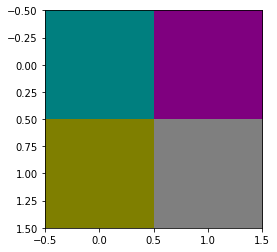

In [5]:
plt.imshow(C_Image/256)
plt.show()

In [10]:
W_Image = np.zeros([2,2,3]) # (x,y,RGB)

W_Image[0,0,:] = (34,   65, 232)
W_Image[0,1,:] = (255, 255,   255)
W_Image[1,0,:] = (228, 128, 54)
W_Image[1,1,:] = (54, 54, 54)

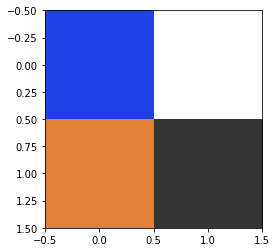

In [11]:
plt.imshow(W_Image/256)
plt.show()

In [17]:
def get_Coeff(Image, watermark=None):
    """ Function that takes in an RGB image matrix of any size and shape and returns qubit coefficients"""
    
    ## build in check sizes Image and watermark are the same
    Flatten_Image = np.reshape(Image, [np.shape(Image)[0]*np.shape(Image)[1],3])
    Theta = (Flatten_Image[:,0]*2**16 + Flatten_Image[:,1]*2**8 + Flatten_Image[:,2])*np.pi/(2**24-1)
    
    if watermark is None:
        Phi = np.zeros(len(Theta))
    else:  
        Flatten_watermark = np.reshape(watermark, [np.shape(watermark)[0]*np.shape(watermark)[1],3])
        Phi = (Flatten_watermark[:,0]*2**16 + Flatten_watermark[:,1]*2**8 + Flatten_watermark[:,2])*np.pi/(2**24-1)

    N = np.ceil(np.log2(np.shape(Image)[0]*np.shape(Image)[1]))/2
    return 1/(2**N)*np.ndarray.flatten(np.transpose(np.stack((np.cos(Theta/2),np.exp(1j*Phi)*np.sin(Theta/2)))))

In [21]:
State_vector = get_Coeff(C_Image, W_Image)

In [20]:
def initialise_state(desired_initial_state):
    n = int(round(np.log2(desired_initial_state.size)))
    
    # if 2**n != desired_initial_state.size:
        # don't run
    
    qc_init = QuantumCircuit(n)

    qc_init.initialize(desired_initial_state, range(n))
    return qc_init

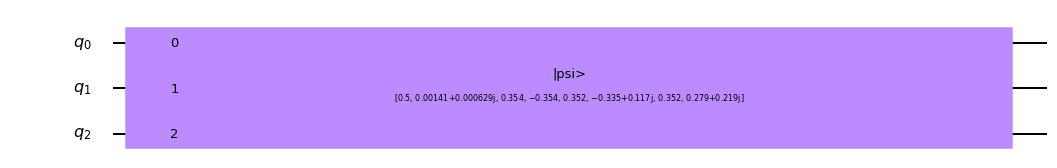

In [22]:
qc_init = initialise_state(State_vector)
qc_init.draw('mpl')

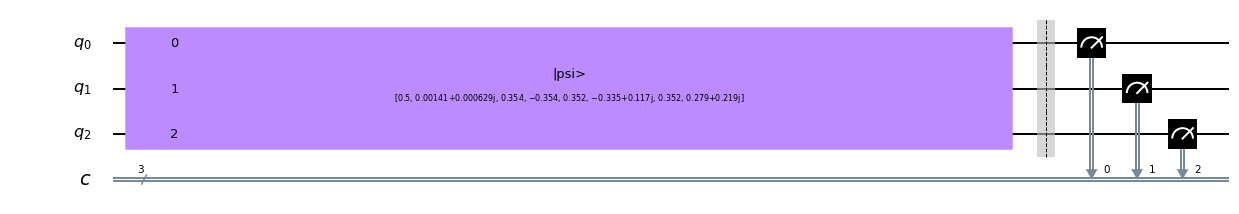

In [37]:
n = int(round(np.log2(State_vector.size)))
shots0 = 4100

# Create a Quantum Circuit
meas = QuantumCircuit(n, n)
meas.barrier(range(n))
# map the quantum measurement to the classical bits
meas.measure(range(n), range(n))

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc_init + meas

#drawing the circuit
qc.draw('mpl')

In [38]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc, backend_sim, shots=shots0)

# Grab the results from the job.
result_sim = job_sim.result()

{'000': 1057, '010': 534, '101': 510, '011': 522, '111': 501, '100': 500, '110': 476}


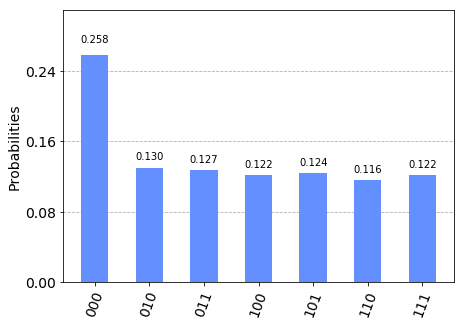

In [56]:
counts = result_sim.get_counts(qc)
print(counts)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [58]:
probability_vector = np.zeros(2**n)
int_counts = counts.int_outcomes() # this changes the keys in the count object to integers so we can iterate through it easily

for k in range(2**n):
    probability_vector[k] = int_counts.get(k, 0)

print(probability_vector)

AttributeError: 'dict' object has no attribute 'int_outcomes'

In [55]:
counts.get(8,0)

0

In [52]:
a

6